# 07 TRAs

## Notebook setup

In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import warnings, scipy.sparse as sp, matplotlib, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import rc_context
from collections import Counter
import matplotlib.font_manager
import openpyxl
import pyreadr
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
#import magic
#import seaborn as sns
import palantir
import loompy
import feather
import re
#from scipy.sparse import csgraph

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rc('font', size=14)
import matplotlib.lines as lines

pd.set_option('display.max_rows', 200)

sc.set_figure_params(dpi=80, dpi_save=300, color_map='Spectral_r', vector_friendly=True, transparent=True)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
/Users/akousa/opt/anaconda3/envs/KousaJahnZhao_et_al_2023/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.2 scipy==1.5.3 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
user_defined_palette =  [ '#F6222E', '#FEAF16','#3283FE','#BDCDFF', '#3B00FB', '#F8A19F', '#1CFFCE',  '#C4451C', 
                          '#2ED9FF', '#c1c119', '#8b0000', '#FE00FA', '#1CBE4F','#B5EFB5', '#0e452b', '#AA0DFE']

In [3]:
user_defined_cmap_markers = LinearSegmentedColormap.from_list('mycmap', ["#E6E6FF", "#CCCCFF", "#B2B2FF", "#9999FF",  "#6666FF",   "#3333FF", "#0000FF"])
user_defined_cmap_degs = LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#3333FF", "#6666FF", "#9999FF", "#B2B2FF", "#CCCCFF", "#E6E6FF", "#E6FFE6", "#CCFFCC", "#B2FFB2", "#99FF99", "#66FF66", "#33FF33", "#00FF00"])

In [4]:
%matplotlib inline 

## Load annotated Figure 1

In [5]:
path_to_h5ad = '../output/anndata_io/Fig1pt1_annotated.h5ad'

In [6]:
#adata_d0.write(path_to_h5ad)

In [7]:
adata_d0 = sc.read_h5ad(path_to_h5ad)
adata_d0.uns['log1p']["base"] = None

In [8]:
adata_d0.shape

(22932, 27657)

In [9]:
TEC_d0 = adata_d0[(adata_d0.obs['cell_type']=='TEC')]

In [10]:
# Remove columns with all 0s
sc.pp.filter_genes(TEC_d0, min_cells=1)

filtered out 651 genes that are detected in less than 1 cells


In [11]:
sc.pp.highly_variable_genes(TEC_d0, n_top_genes=3500, n_bins=20, flavor='seurat')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [12]:
rng = np.random.RandomState(42)
sc.tl.pca(TEC_d0, n_comps=50, svd_solver='arpack', random_state=rng, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [13]:
sce.pp.harmony_integrate(TEC_d0, 'sample')

2024-04-08 16:20:45,722 - harmonypy - INFO - Iteration 1 of 10
2024-04-08 16:20:46,555 - harmonypy - INFO - Iteration 2 of 10
2024-04-08 16:20:47,337 - harmonypy - INFO - Iteration 3 of 10
2024-04-08 16:20:48,111 - harmonypy - INFO - Iteration 4 of 10
2024-04-08 16:20:48,682 - harmonypy - INFO - Converged after 4 iterations


In [14]:
sc.pp.neighbors(TEC_d0, n_neighbors=15, use_rep='X_pca_harmony')
sc.tl.umap(TEC_d0)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


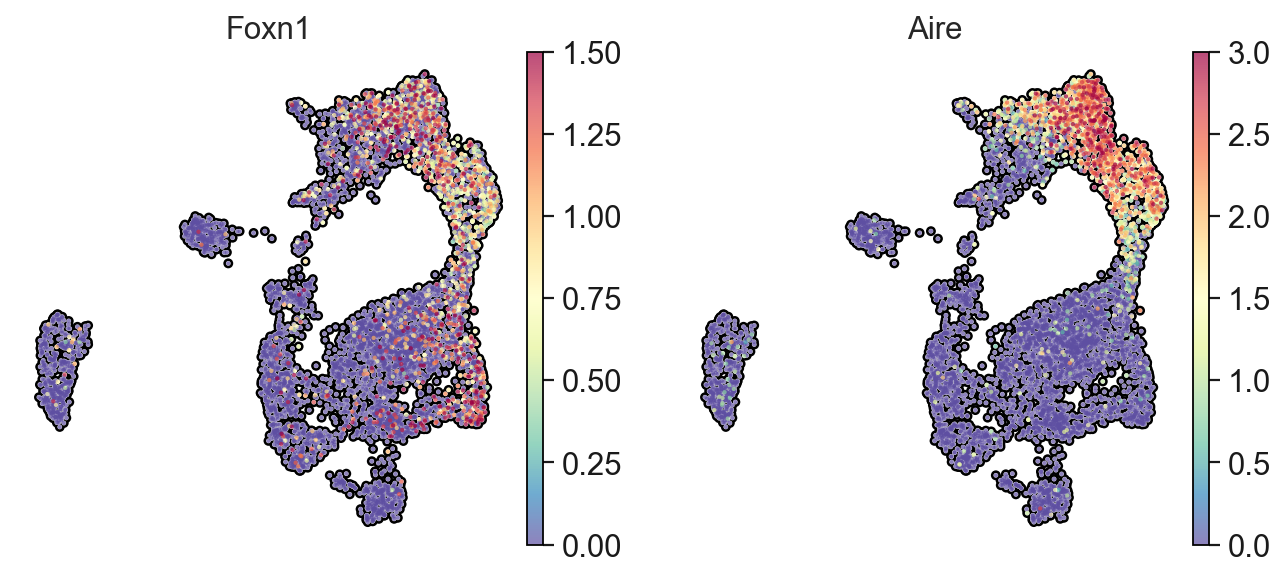

In [15]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

sc.pl.umap(
    TEC_d0, 
    color=['Foxn1', 'Aire'], 
    palette=user_defined_palette,  
    color_map='Spectral_r', 
    use_raw=False,
    ncols=9,
    wspace = 0.2,
    outline_width=[0.6, 0.05],
    size=15,
    frameon=False,
    add_outline=True,
    sort_order = True,
    vmin=0,
    vmax=[1.5,3]
)

### TRA expression

In [16]:
TEC_18mo = TEC_d0[(TEC_d0.obs['stage']=='18mo')]

In [17]:
Fezf2_dep = ['Fezf2', 'Ttr', 'Krt10', 'Resp18', 'Fabp9', 'Apoc3', 'Csrnp3', 'Klk1b16', 'C530008M17Rik', 'Maoa', 'Smtnl1', 'Calb1', 'Cd177', 'Timd2', 'Pck1', 'Nol4', 'Bbox1']
Fezf2_indep = ['Hspa1l',	'Hsp90aa1',	'Ezr',	'Fbp1',	'Rab6a',	'Pdcd6ip',	'Acsm3',	'Rab6b',	'Ppib',	'Sardh',	'Ran',	'Rac3',	'Rhoc',	'Anpep',	'Tcp1',	'Jup',	'Rasl2-9',	'Rps11',	'Sult1d1',	'Pacsin2',	'Pgam2',	'Cat',	'Nid1',	'Xylb',	'Mvp',	'Acsf2',	'Ywhae',	'Eif3f']
Aire_dep = ['Tnfrsf11a', 'Cd40', 'Aire','Csn1s1', 'Reg3b', 'Ins2', 'S100a8', 'Igsf5', 'Penk', 'Mup1', 'Tff3', 'S100a9', 'Mup5', 'Fgg', 'H19', 'Scgb1a1', 'Igf2', 'Sprr2f']
Aire_indep = ['Col1a1', 'Col1a2', 'Nid2', 'Ndufs1', 'Lmnb1', 'Mvp', 'Fn1', 'Thbs1', 'Hk1', 'Dcn', 'Spta1', 'Krt7', 'Sptb', 'Fabp4', 'Etfdh', 'Cgnl1', 'Kif5b', 'Vill', 'Ogdh', 'Vdac3', 'Krt84', 'Ap2a1', 'Rhoc', 'Dhx9', 'Psmd2', 'Hnrnpu', 'Hnrnpc', 'Serpinc1']

In [18]:
sc.tl.score_genes(TEC_18mo, gene_list = Fezf2_dep,  score_name='Fezf2 dependent', use_raw=False)
sc.tl.score_genes(TEC_18mo, gene_list = Fezf2_indep,  score_name='Fezf2 independent', use_raw=False)
sc.tl.score_genes(TEC_18mo, gene_list = Aire_dep,  score_name='Aire dependent', use_raw=False)
sc.tl.score_genes(TEC_18mo, gene_list = Aire_indep,  score_name='Aire independent', use_raw=False)

computing score 'Fezf2 dependent'
    finished: added
    'Fezf2 dependent', score of gene set (adata.obs).
    548 total control genes are used. (0:00:00)
computing score 'Fezf2 independent'
    finished: added
    'Fezf2 independent', score of gene set (adata.obs).
    748 total control genes are used. (0:00:00)
computing score 'Aire dependent'
    finished: added
    'Aire dependent', score of gene set (adata.obs).
    600 total control genes are used. (0:00:00)
computing score 'Aire independent'
    finished: added
    'Aire independent', score of gene set (adata.obs).
    548 total control genes are used. (0:00:00)


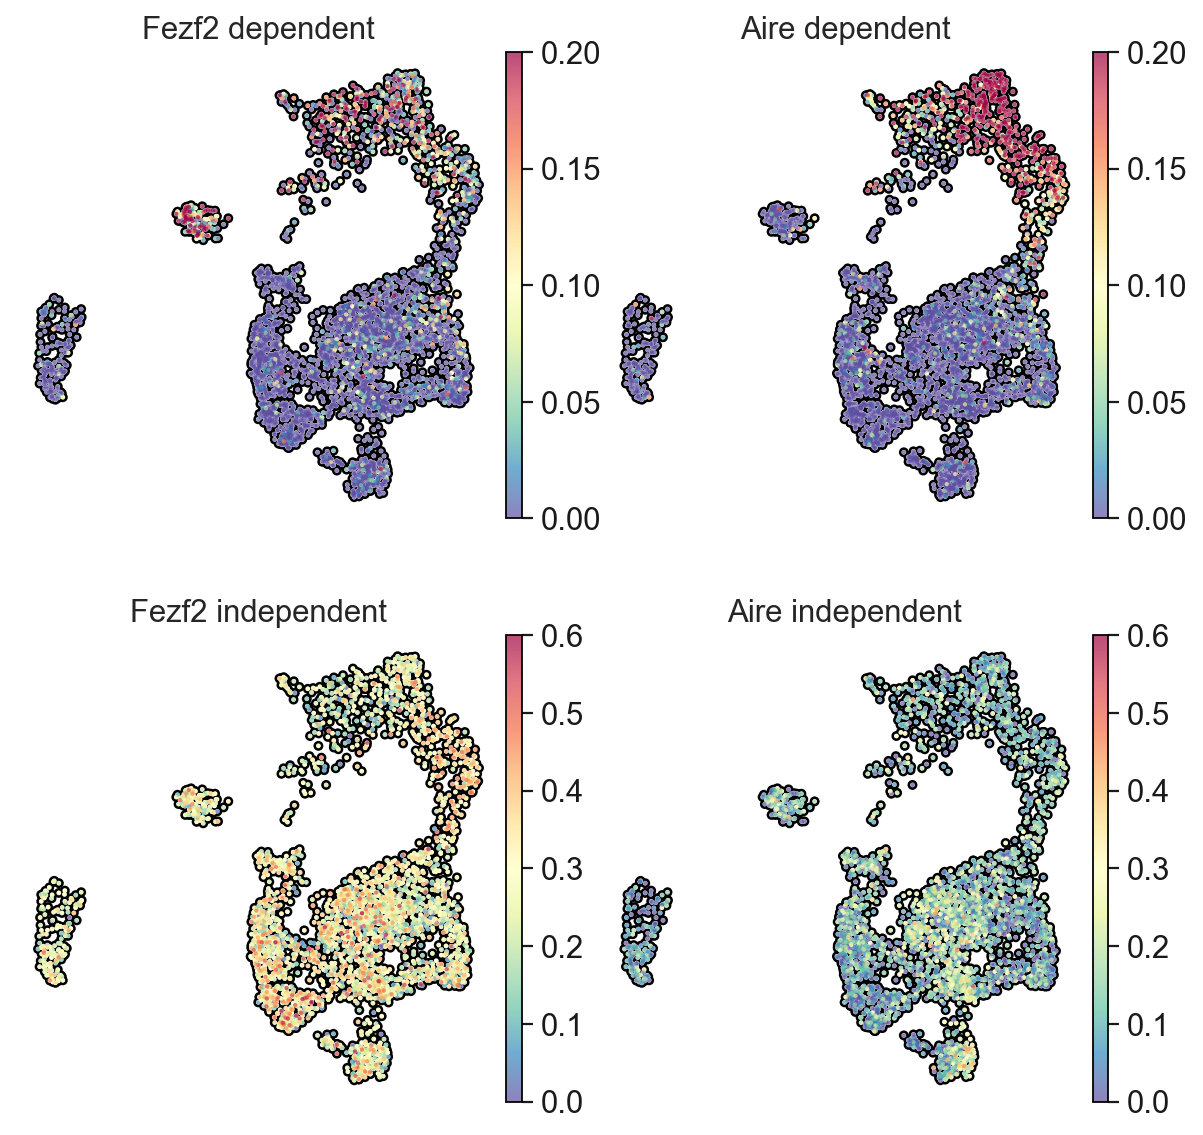

In [19]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='Spectral_r', vector_friendly=True, transparent=True)

sc.pl.umap(TEC_18mo, color=['Fezf2 dependent',  'Aire dependent', 'Fezf2 independent', 'Aire independent'], 
                     color_map='Spectral_r',
                     use_raw=False, 
                     ncols=2, 
                     wspace = 0.1,
                     outline_width=[0.6, 0.05], 
                     size=15,  
                     vmin=0,
                     vmax=[0.2, 0.2, 0.6, 0.6],
                     frameon=False, 
                     add_outline=True
)

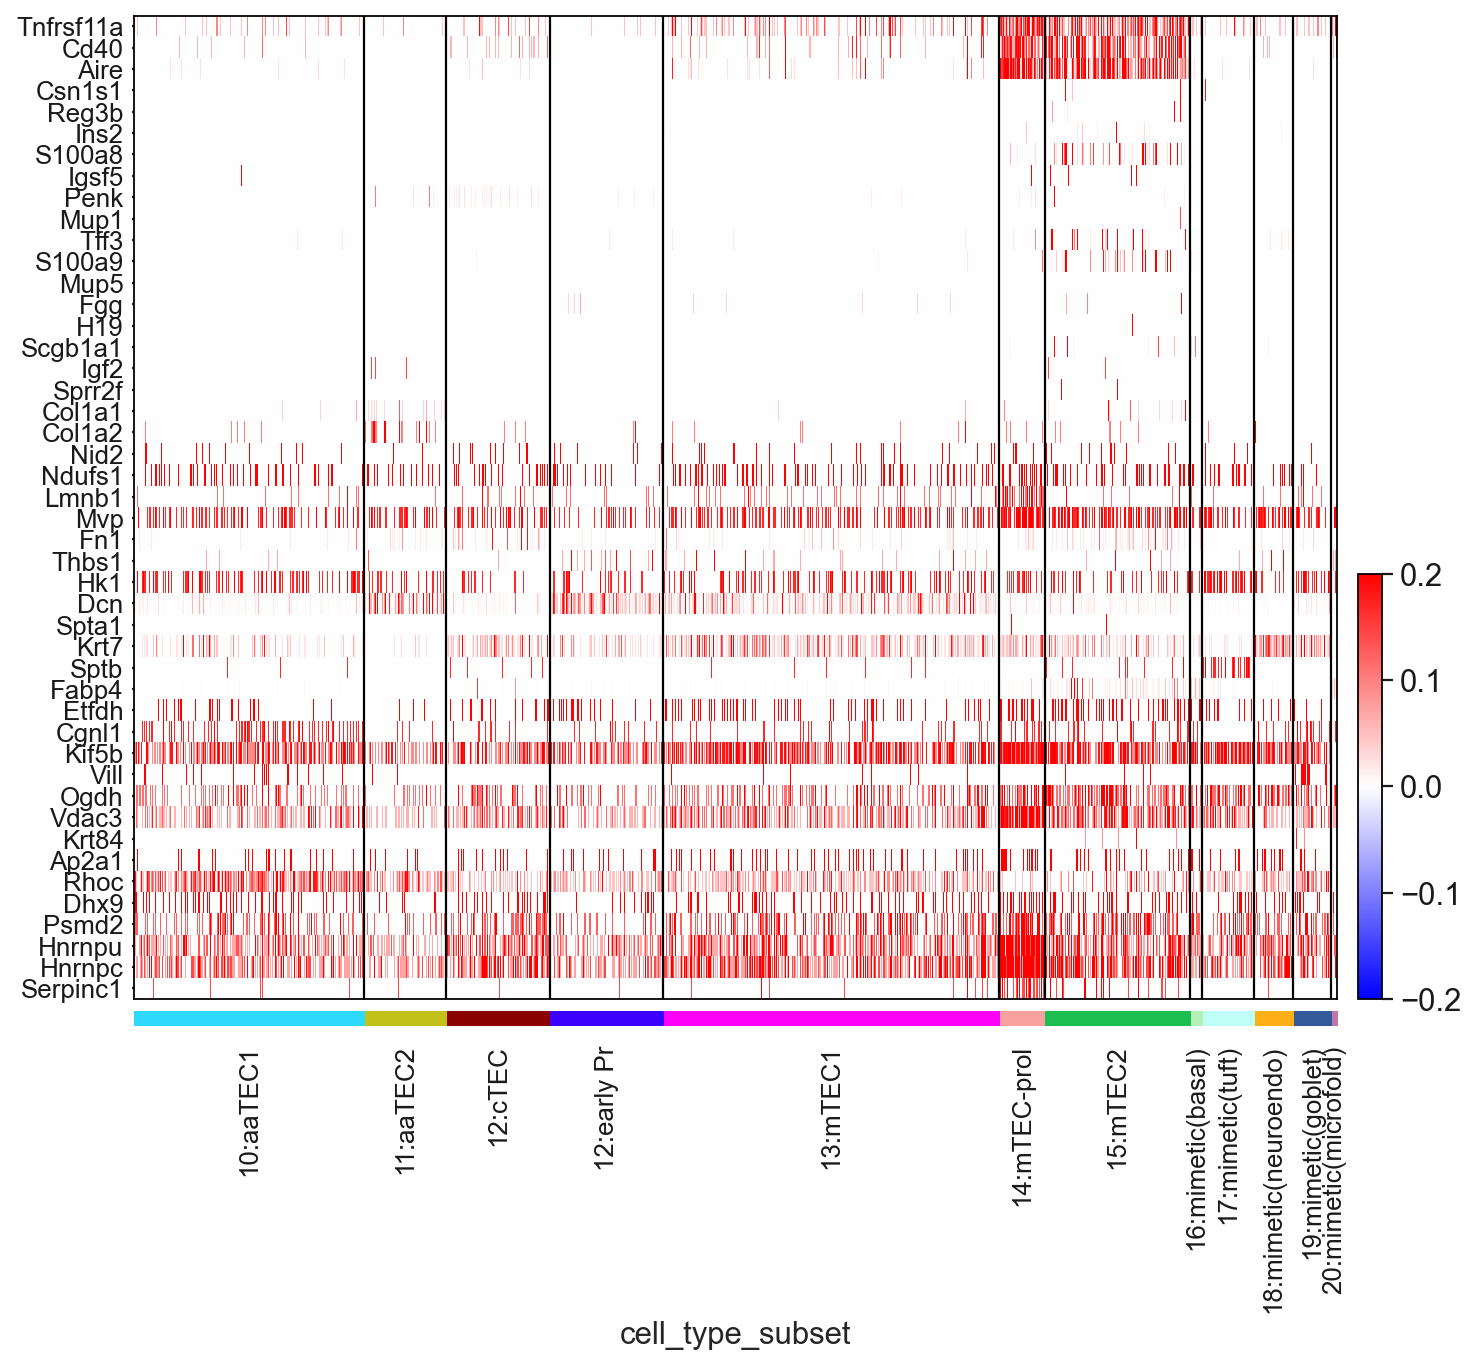

In [20]:
sc.pl.heatmap(TEC_18mo, var_names=Aire_dep+Aire_indep, groupby='cell_type_subset', swap_axes=True, standard_scale='var', dendrogram=False,  cmap='bwr', vmin=-0.2, vmax=0.2)

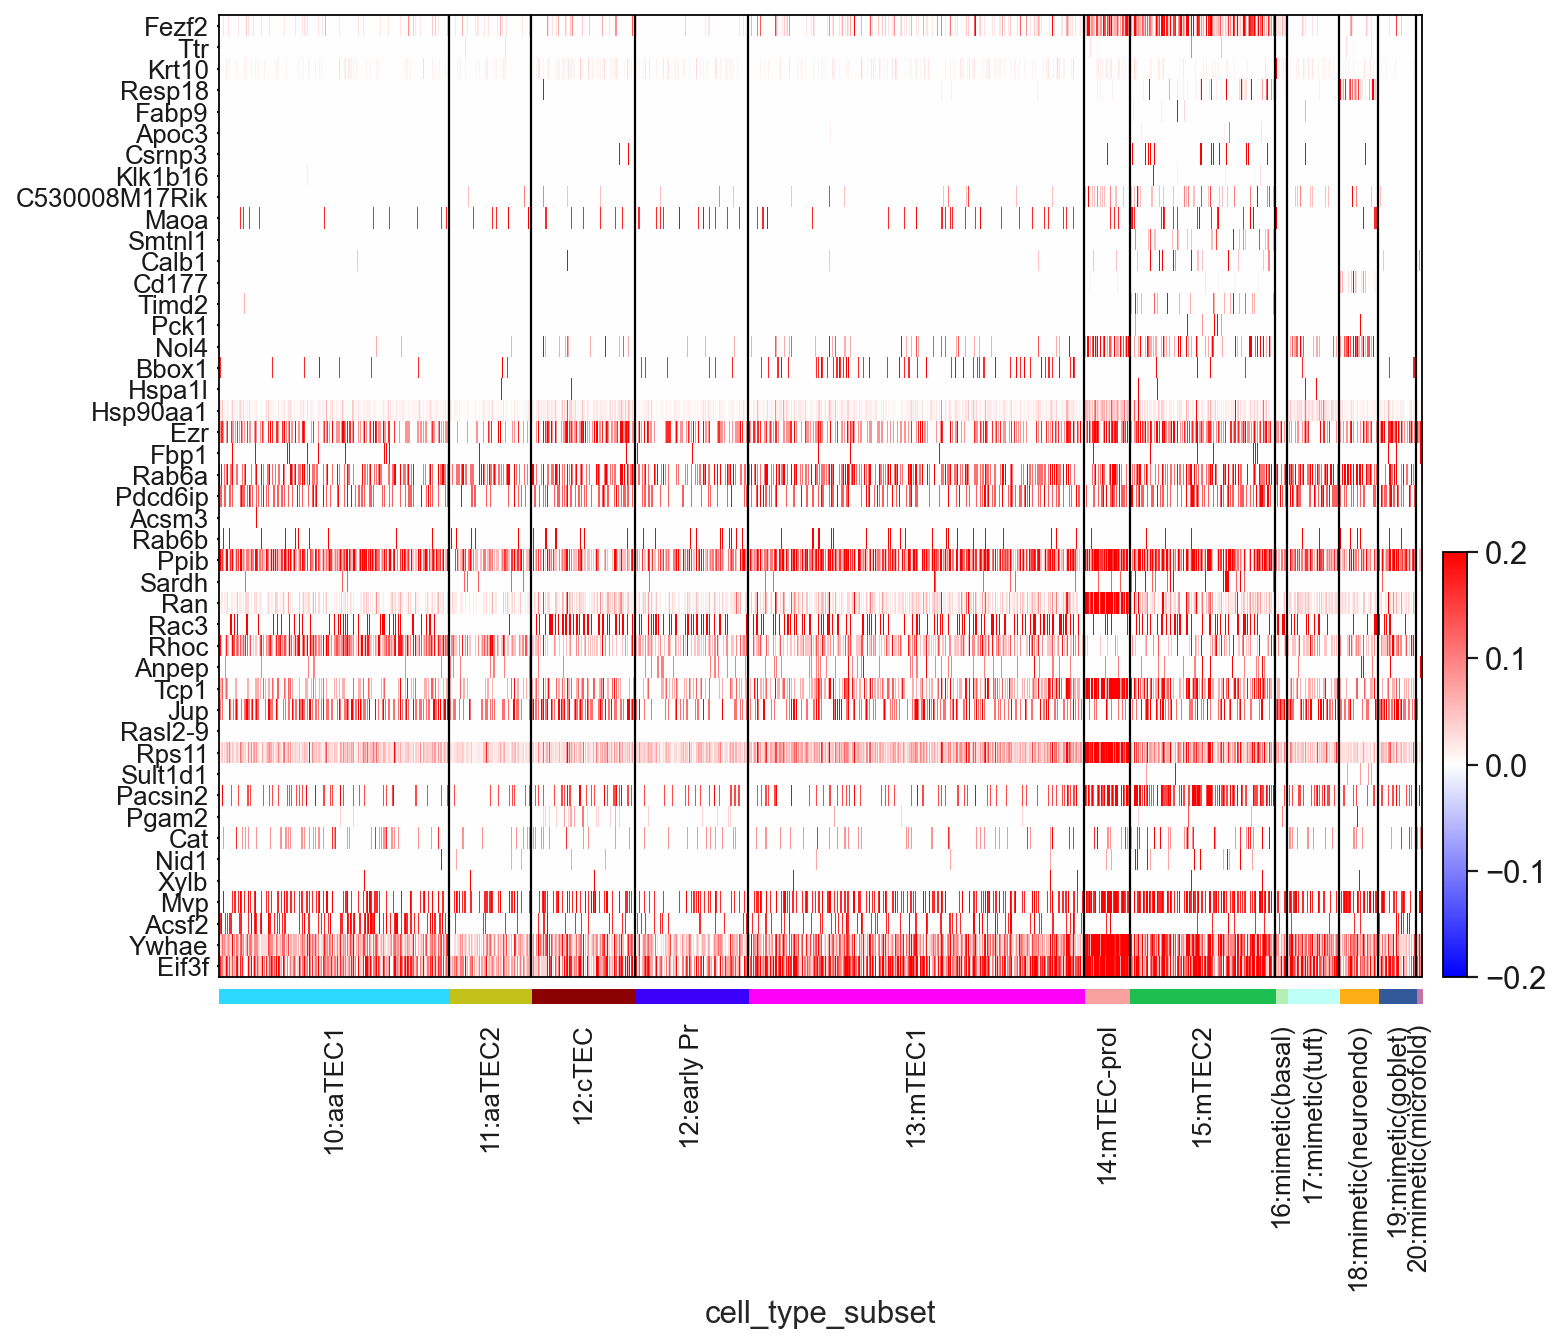

In [21]:
sc.pl.heatmap(TEC_18mo, var_names=Fezf2_dep+Fezf2_indep, groupby='cell_type_subset', swap_axes=True, standard_scale='var', dendrogram=False,  cmap='bwr', vmin=-0.2, vmax=0.2)